# Santiago de Chile's Commune clusterization based on most common food venues categories.

Initiially instaLl this, then retsart the kernel:

In [1]:
#!pip install geopy
#!pip install folium
#!pip install lxml
#!pip install geocoder

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
pd.set_option('display.max_rows', 500)

import folium # plotting library
import matplotlib.cm as cm
import matplotlib.colors as colors

## We first get the table with latitude and longitude from the wikipedia article.

In [3]:
url = "https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile"

tables = pd.read_html(url ,header=0)[0]
tables.head()

,CUT (Código Único Territorial),Nombre,Unnamed: 2,Provincia,Región,Superficie(km2),Población2017,Densidad(hab./km2),IDH 2005,IDH 2005.1,Latitud,Longitud
0,15101,Arica,NaN,Arica,Arica y Parinacota,47994,221 364,046,384.0,Alto,"-18°27'18""","-70°17'24"""
1,15102,Camarones,NaN,Arica,Arica y Parinacota,3927,1255,032,751.0,Alto,"-19°1'1,2""","-69°52'1,2"""
2,15201,Putre,NaN,Parinacota,Arica y Parinacota,59025,2765,047,707.0,Alto,"-18°12'0""","-69°34'58,8"""
3,15202,General Lagos,NaN,Parinacota,Arica y Parinacota,22444,684,031,67.0,Medio,"-17°39'10,8""","-69°38'6"""
4,1101,Iquique,NaN,Iquique,Tarapacá,22421,191 468,854,766.0,Alto,"-20°14'38,4""","-70°8'20,4"""


## Now we keep only the province of Santiago since is the center of our study:

In [4]:
df_santiago = tables[tables['Provincia'] == 'Santiago'][['Nombre', 'Latitud', 'Longitud']].copy()
df_santiago.columns = ['Commune', 'Latitude', 'Longitude']
df_santiago.head()

,Commune,Latitude,Longitude
294,Santiago,"-33°26'14""","-70°39'26"""
295,Cerrillos,"-33°30'0""","-70°43'0"""
296,Cerro Navia,"-33°25'19,2""","-70°44'6"""
297,Conchalí,"-33°22'48""","-70°40'30"""
298,El Bosque,"-33°34'1,2""","-70°40'30"""


## Since the format of the latitudes and longitudes is non-numeric, we create a function to transform the HMS format of coordinates to numerical/georeferential format:

In [5]:
def TrasformCoordinates(s):
    a = s.replace(r'"', '')
    split1 = a.split('°')
    
    signo = np.sign(float(split1[0]))
    horas = abs(float(split1[0]))
    
    split2= split1[1].split(r"'")
    
    minutos = float(split2[0])/60
    
    segundos = float(split2[1].replace(',', '.'))/(60*60)
    
    coordenate = (horas+minutos+segundos)*signo
    
    return coordenate

test = df_santiago.iloc[2, 1]

print('This coordenate: ', test)
print('Becomes: ', TrasformCoordinates(test))

This coordenate:  -33°25'19,2"
Becomes:  -33.422


We apply the function to the corresponding columns:

In [6]:
df_santiago['Latitude'] = df_santiago['Latitude'].apply(lambda x: TrasformCoordinates(x))
df_santiago['Longitude'] = df_santiago['Longitude'].apply(lambda x: TrasformCoordinates(x))
df_santiago.head()

,Commune,Latitude,Longitude
294,Santiago,-33.437222,-70.657222
295,Cerrillos,-33.500000,-70.716667
296,Cerro Navia,-33.422000,-70.735000
297,Conchalí,-33.380000,-70.675000
298,El Bosque,-33.567000,-70.675000


Now that we have our communes, let's take a look of the overview of the whole province. In order to do that we must aquire the geolocation of the city of Santiago de Chile:

In [7]:
address = 'Santiago, Chile'
try:
    geolocator = Nominatim(user_agent="camilo_capstone_project")
    location = geolocator.geocode(address)
    santiago_latitude = location.latitude
    santiago_longitude = location.longitude
    print('Nominatim responded...')
except:
    santiago_latitude = -33.4377968
    santiago_longitude = -70.6504451
    print('An error ocurred, so we impose...')
print('The geograpical coordinate of Santiago de Chile are {}, {}.'.format(santiago_latitude, santiago_longitude))

Nominatim responded...
The geograpical coordinate of Santiago de Chile are -33.4377968, -70.6504451.


No we declare a few variables that will be helpful later, radius is set to 1 Km (1000 meters) initially since it's a Foursquare parameter and we will expand thsi radius (if necessary) to aquire a reasonable amount of samples.

In [8]:
initial_radius = 1000
df_santiago['radius'] = initial_radius
section = 'food'

In [9]:
map_santiago = folium.Map(location=[santiago_latitude, santiago_longitude], zoom_start=11)

for lat, lng, commune, radius in zip(df_santiago['Latitude'], df_santiago['Longitude'], df_santiago['Commune'], df_santiago['radius']):
    label = commune
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_santiago) 
    
    folium.Circle([lat, lng],
                    radius=radius
                   ).add_to(map_santiago)
    
map_santiago

Now let's set up our Foursquare's credentials...

In [10]:
#CLIENT_ID = 'M5CC5TITMVFEF40ZJYXIBJIBU0BP0MDPWE0MAYMXTF30S0WV' # your Foursquare ID
#CLIENT_SECRET = 'IKXKQXWHVMSEYU1P1EG5QLHN0X5FL5M2YAKI1A111JTHQZJW' # your Foursquare Secret
CLIENT_ID = 'ETKTEI0DGPT1JTVIGMTGB0VBNRJ5M52G1U0YCLT22HD3ZSPY' #id2
CLIENT_SECRET = 'FSB0IX5GXIUVE5XVPUDVSLXUT3SYH5OE0SMLPYAYG1E5DAMB' # your Foursquare Secre

VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)

Your credentails:
CLIENT_ID: ETKTEI0DGPT1JTVIGMTGB0VBNRJ5M52G1U0YCLT22HD3ZSPY


Now we will explore some food venues for the Vitacura commune to se a precise example of the data we will be dealing with:

In [11]:
vita_df = df_santiago[df_santiago['Commune'] == 'Vitacura']
vita_name = vita_df.iloc[0,0]
vita_latitude = vita_df.iloc[0,1]
vita_longitude = vita_df.iloc[0,2]
vita_radius = vita_df.iloc[0,3]
print(vita_name, vita_latitude, vita_longitude, vita_radius)

Vitacura -33.378 -70.562 1000


We make the request to the folium API, notice that we pass the radisu aprameter and the section parameter that contains the 'food' stirng that indicates we will limitate our exploration to food associatated venues:

In [12]:
LIMIT = 100 #Maximum number of venues that Foursquare can respond...

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    vita_latitude, 
    vita_longitude, 
    vita_radius,
    section,
    LIMIT)

And we store the results:

In [13]:
results = requests.get(url).json()
#results #Uncomment this to see the format of the response.

We define a function that extracts the category of the venue:

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

And we take a pic of the results:

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Zuki Louge & Nikkei,Sushi Restaurant,-33.385687,-70.559630
1,La Chocolatine,Bakery,-33.386412,-70.563223
2,Restaurante Gran Museo Peruano,Peruvian Restaurant,-33.385076,-70.556429
3,La Cocina De Javier,Paella Restaurant,-33.385860,-70.561043
4,Panadería Las Rosas Chicas,Bakery,-33.381580,-70.571487


In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

17 venues were returned by Foursquare.


Let's overve where this venues are located...

In [17]:
map_vitacura = folium.Map(location=[vita_latitude, vita_longitude], zoom_start=15)

for lat, lng, venue in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vitacura)


    
folium.Circle([vita_latitude, vita_longitude],
                    radius=radius
                   ).add_to(map_vitacura)
    
map_vitacura

And now let's sort the categories of the resulting venues to see the most common ones...

In [18]:
vita_categories = nearby_venues.groupby(['categories']).count()
vita_categories.drop(columns=['lat', 'lng'], inplace=True)
vita_categories.columns = ['Count']
vita_categories.sort_values(by=['Count'], inplace=True,ascending=False)
vita_categories.head()

,Count
categories,
Sandwich Place,3
Sushi Restaurant,3
Bakery,2
Peruvian Restaurant,2
Bistro,1


We import some libraries for plotting purposes...

In [19]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

And we plot the non-unique categories results:

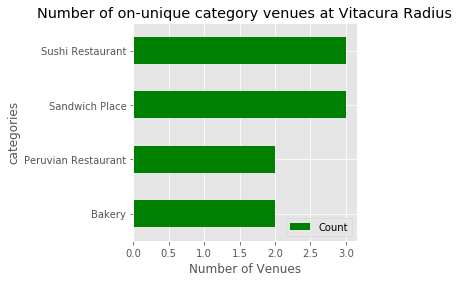

In [20]:
vita_categories.sort_values(by=['Count'], inplace=True,ascending=True)

vita_categories = vita_categories[vita_categories['Count'] != 1]

vita_categories.plot(kind='barh', figsize=(4, 4), color='green')
plt.xlabel('Number of Venues')
plt.title('Number of on-unique category venues at Vitacura Radius')
    
plt.show()

Now let's take this excercise for the whole group of communes. We first start by definning a function that we'll do the request for each one of the communes:

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radius):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            section,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Commune', 
                  'Commune Latitude', 
                  'Commune Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We no use the function to get the first results...

In [22]:
stgo_food_venues = getNearbyVenues(names=df_santiago['Commune'],
                                   latitudes=df_santiago['Latitude'],
                                   longitudes=df_santiago['Longitude'],
                                   radius=df_santiago['radius']
                                  )

In [81]:
print(stgo_food_venues.shape)
stgo_food_venues.head()

(731, 7)


,Commune,Commune Latitude,Commune Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Santiago,-33.437222,-70.657222,Amanda's,-33.439206,-70.658247,Arepa Restaurant
1,Santiago,-33.437222,-70.657222,Bambudda,-33.438987,-70.655631,Asian Restaurant
2,Santiago,-33.437222,-70.657222,GYROS BISTRÓ,-33.439793,-70.655792,Sandwich Place
3,Santiago,-33.437222,-70.657222,Milano's Pizza,-33.437036,-70.657385,Pizza Place
4,Santiago,-33.437222,-70.657222,FuriSushi,-33.436130,-70.662690,Sushi Restaurant


Let's see how many venues there are for each commune:

In [24]:
neigh_venues = stgo_food_venues[['Commune','Venue']].groupby('Commune').count()
neigh_venues.transpose()

Commune,Cerrillos,Cerro Navia,Conchalí,El Bosque,Estación Central,Huechuraba,Independencia,La Cisterna,La Florida,La Granja,...,Quilicura,Quinta Normal,Recoleta,Renca,San Joaquín,San Miguel,San Ramón,Santiago,Vitacura,Ñuñoa
Venue,4,7,5,6,37,4,27,33,1,4,...,22,20,15,6,17,33,10,47,17,100


We can observe that some communes have less than 10 venues associated to the response, let's group the communes with less than 10 venues:

In [26]:
faltantes = neigh_venues[neigh_venues['Venue'] < 10].index #this is a list
faltantes

df_santiago_faltantes = df_santiago.loc[df_santiago['Commune'].isin(faltantes)]
print(faltantes.shape)
df_santiago_faltantes

(18,)


,Commune,Latitude,Longitude,radius
295,Cerrillos,-33.500000,-70.716667,1000
296,Cerro Navia,-33.422000,-70.735000,1000
297,Conchalí,-33.380000,-70.675000,1000
298,El Bosque,-33.567000,-70.675000,1000
300,Huechuraba,-33.368000,-70.634000,1000
303,La Florida,-33.525000,-70.538000,1000
304,La Granja,-33.533333,-70.625000,1000
305,La Pintana,-33.583000,-70.634000,1000
306,La Reina,-33.443000,-70.532000,1000
308,Lo Barnechea,-33.352000,-70.336000,1000


So now we're going to increase the radius of the request by 200 for each commune that doesn't have at least 10 venues associated with it until we have at least 10 venues per commune:

_(**Important note:** the criteria behind the amount of increase and the number of venues was based on the amount of request you can perform with a free account with Foursquare based, it is highly suggested to increase this amount if you have the possibility.)_

In [27]:
while len(faltantes) > 0:

    df_santiago.loc[df_santiago['Commune'].isin(faltantes), 'radius'] += 200
    df_santiago_faltantes = df_santiago.loc[df_santiago['Commune'].isin(faltantes)]

    stgo_food_venues = stgo_food_venues[-stgo_food_venues['Commune'].isin(faltantes)]

    try:
        new_neigh_venues = getNearbyVenues(names=df_santiago_faltantes['Commune'],
                                latitudes=df_santiago_faltantes['Latitude'],
                                longitudes=df_santiago_faltantes['Longitude'],
                                radius=df_santiago_faltantes['radius']
                                    )

        stgo_food_venues = stgo_food_venues.append(new_neigh_venues)
    except:
        pass

    neigh_venues = stgo_food_venues[['Commune','Venue']].groupby('Commune').count()
    faltantes = neigh_venues[neigh_venues['Venue'] < 10].index #this is a list

    print(len(faltantes), ' left with less than 20 venues...')

16  left with less than 20 venues...
14  left with less than 20 venues...
13  left with less than 20 venues...
12  left with less than 20 venues...
10  left with less than 20 venues...
5  left with less than 20 venues...
5  left with less than 20 venues...
5  left with less than 20 venues...
4  left with less than 20 venues...
4  left with less than 20 venues...
3  left with less than 20 venues...
3  left with less than 20 venues...
3  left with less than 20 venues...
3  left with less than 20 venues...
3  left with less than 20 venues...
2  left with less than 20 venues...
1  left with less than 20 venues...
1  left with less than 20 venues...
1  left with less than 20 venues...
1  left with less than 20 venues...
1  left with less than 20 venues...
1  left with less than 20 venues...
1  left with less than 20 venues...
1  left with less than 20 venues...
0  left with less than 20 venues...


## Since there is a limited amount of request you can make with a free developper account at Foursquare, we store the results:

In [28]:
import pickle
df_santiago.to_pickle('df_santiago') 
stgo_food_venues.to_pickle('stgo_food_venues') 
neigh_venues.to_pickle('neigh_venues') 

In [64]:
import pickle
stgo_food_venues = pd.read_pickle('stgo_food_venues')
neigh_venues = pd.read_pickle('neigh_venues')
df_santiago = pd.read_pickle('df_santiago')

Now let's take a look:

In [65]:
print(stgo_food_venues.shape)
stgo_food_venues.head()

(731, 7)


,Commune,Commune Latitude,Commune Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Santiago,-33.437222,-70.657222,Amanda's,-33.439206,-70.658247,Arepa Restaurant
1,Santiago,-33.437222,-70.657222,Bambudda,-33.438987,-70.655631,Asian Restaurant
2,Santiago,-33.437222,-70.657222,GYROS BISTRÓ,-33.439793,-70.655792,Sandwich Place
3,Santiago,-33.437222,-70.657222,Milano's Pizza,-33.437036,-70.657385,Pizza Place
4,Santiago,-33.437222,-70.657222,FuriSushi,-33.436130,-70.662690,Sushi Restaurant


In [66]:
neigh_venues.transpose()

Commune,Cerrillos,Cerro Navia,Conchalí,El Bosque,Estación Central,Huechuraba,Independencia,La Cisterna,La Florida,La Granja,...,Quilicura,Quinta Normal,Recoleta,Renca,San Joaquín,San Miguel,San Ramón,Santiago,Vitacura,Ñuñoa
Venue,12,11,12,10,37,12,26,33,10,10,...,22,20,15,12,17,36,10,48,17,100


Since our criteria has been match, let's graph how this new agrrupation looks like:

In [67]:
map_santiago = folium.Map(location=[santiago_latitude, santiago_longitude], zoom_start=11)

for lat, lng, commune, radius in zip(df_santiago['Latitude'], df_santiago['Longitude'], df_santiago['Commune'], df_santiago['radius']):
    label = commune
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_santiago) 
    
    folium.Circle([lat, lng],
                    radius=radius
                   ).add_to(map_santiago)
for lat, lng, venue in zip(stgo_food_venues['Venue Latitude'], stgo_food_venues['Venue Longitude'], stgo_food_venues['Venue Category']):
    label = commune
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_santiago) 
    
map_santiago

Those are the final radius we will be using to match our criteria:

In [68]:
df_santiago[['Commune', 'radius']].transpose()

,294,295,296,297,298,299,300,301,302,303,...,316,317,318,319,320,321,322,323,324,325
Commune,Santiago,Cerrillos,Cerro Navia,Conchalí,El Bosque,Estación Central,Huechuraba,Independencia,La Cisterna,La Florida,...,Providencia,Pudahuel,Quilicura,Quinta Normal,Recoleta,Renca,San Joaquín,San Miguel,San Ramón,Vitacura
radius,1000,1200,1800,1400,1600,1000,2000,1000,1000,1600,...,1000,4200,1000,1000,1000,1800,1000,1000,1000,1000


Now let's borrow the encodement to transform each row in a boolean like form:

In [69]:
# one hot encoding
stgo_onehot = pd.get_dummies(stgo_food_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
stgo_onehot['Commune'] = stgo_food_venues['Commune'] 

# move neighborhood column to the first column
fixed_columns = [stgo_onehot.columns[-1]] + list(stgo_onehot.columns[:-1])
stgo_onehot = stgo_onehot[fixed_columns]

stgo_onehot.head()

,Commune,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wings Joint
0,Santiago,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Santiago,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Santiago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Santiago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Santiago,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [70]:
stgo_onehot.shape

(731, 62)

## Let's see what are the most common venues in our dataset:

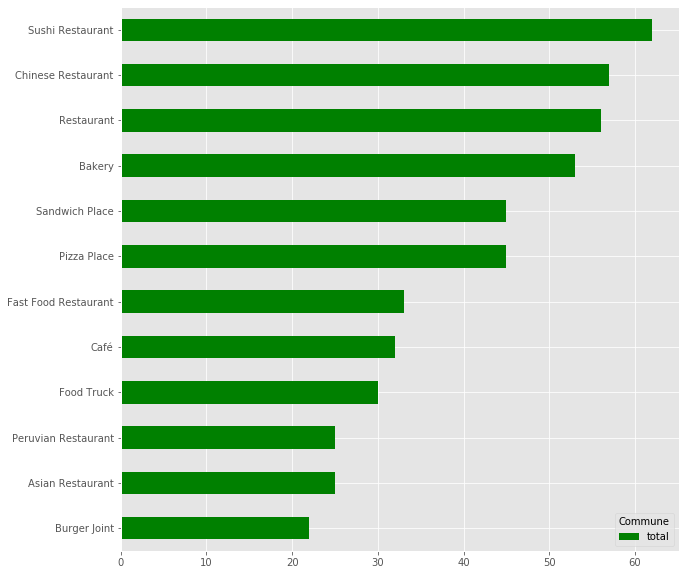

In [83]:
g = stgo_onehot.groupby('Commune').sum()
g = g.transpose()
g['total'] = g.sum(axis=1)
g = g[['total']]

g = g[g['total'] > 20]

g.sort_values(by=['total'], inplace=True,ascending=True)


g.plot(kind='barh', figsize=(10, 10), color='green')

Let's now group by mean...

In [72]:
stgo_grouped = stgo_onehot.groupby('Commune').mean().reset_index()
stgo_grouped.head()

,Commune,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wings Joint
0,Cerrillos,0.0,0.0,0.000000,0.166667,0.083333,0.0,0.083333,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,Cerro Navia,0.0,0.0,0.000000,0.090909,0.000000,0.0,0.181818,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909
2,Conchalí,0.0,0.0,0.000000,0.000000,0.083333,0.0,0.083333,0.0,0.0,...,0.000000,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.000000
3,El Bosque,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.100000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,Estación Central,0.0,0.0,0.027027,0.054054,0.000000,0.0,0.135135,0.0,0.0,...,0.027027,0.0,0.0,0.054054,0.0,0.0,0.0,0.0,0.0,0.000000


In [73]:
stgo_grouped.shape

(32, 62)

Let's now group by the 3 most common venues:

_(**Important note:** I chose to work with the 3 mos commons since in order to categorize after the clusterization, this will give us a more clear distinction between clusters.)_

In [99]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [100]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Commune']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Commune'] = stgo_grouped['Commune']

for ind in np.arange(stgo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stgo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Commune,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Cerrillos,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant
1,Cerro Navia,Bakery,Wings Joint,Sandwich Place
2,Conchalí,Chinese Restaurant,Fried Chicken Joint,Food Truck
3,El Bosque,Food Truck,Fried Chicken Joint,Bakery
4,Estación Central,Bakery,Pizza Place,Fast Food Restaurant


Now let's use the k-means algorithm for clustering...

In [101]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

We're going to iterate from 1 to 10 clusters with k-means in order to graph the results and select a proper k based on the elbow method...

In [102]:
kclusters = 10
mean_dist = np.zeros((kclusters))

stgo_grouped_clustering = stgo_grouped.drop('Commune', 1)

# run k-means clustering
for n in range(1,kclusters+1):
    
    kmeans = KMeans(n_clusters=n, random_state=3, precompute_distances=True).fit(stgo_grouped_clustering)
    centroids = kmeans.cluster_centers_
    mean_dist[n-1] = kmeans.inertia_

mean_dist

#kmeans.labels_[0:10]

array([2.63157203, 2.32702811, 2.0623496 , 1.85182266, 1.68441783,
       1.4926666 , 1.41689797, 1.33174445, 1.19316204, 1.12321526])

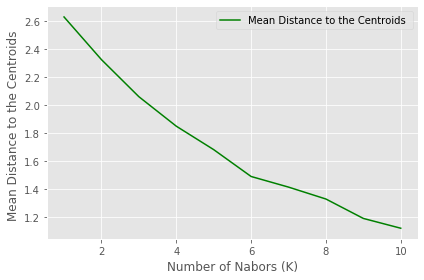

In [103]:
plt.plot(range(1,kclusters+1),mean_dist,'g')
plt.legend(('Mean Distance to the Centroids ', '+/- 3xstd'))
plt.ylabel('Mean Distance to the Centroids ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

6 looks like the elbow point, then we proceed with k=6:

In [104]:
kmeans = KMeans(n_clusters=6, random_state=3, precompute_distances=True).fit(stgo_grouped_clustering)
kmeans.labels_[0:10]

array([1, 4, 1, 2, 4, 3, 1, 1, 0, 4], dtype=int32)

We add the cluster labels to the original dataframe:

In [105]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

stgo_merged = df_santiago

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
stgo_merged = stgo_merged.join(neighborhoods_venues_sorted.set_index('Commune'), on='Commune')

stgo_merged.head() # check the last columns!

,Commune,Latitude,Longitude,radius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
294,Santiago,-33.437222,-70.657222,1000,0,Sandwich Place,Café,Vegetarian / Vegan Restaurant
295,Cerrillos,-33.500000,-70.716667,1200,1,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant
296,Cerro Navia,-33.422000,-70.735000,1800,4,Bakery,Wings Joint,Sandwich Place
297,Conchalí,-33.380000,-70.675000,1400,1,Chinese Restaurant,Fried Chicken Joint,Food Truck
298,El Bosque,-33.567000,-70.675000,1600,2,Food Truck,Fried Chicken Joint,Bakery


Now we plot our final result of clusterisation:

In [106]:
# create map
map_clusters = folium.Map(location=[santiago_latitude, santiago_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, radius in zip(stgo_merged['Latitude'], stgo_merged['Longitude'], stgo_merged['Commune'], stgo_merged['Cluster Labels'], stgo_merged['radius']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    
    folium.Circle([lat, lon],
                    radius=radius,
                  color = rainbow[cluster-1],
                  fill= True,
                  fill_color=rainbow[cluster-1],
                   ).add_to(map_clusters)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In order to name the clusters, we can inspect the most recurrent categories beneath the clusters:

In [107]:
only_venues = columns.copy()
only_venues.remove("Commune")
only_venues

['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']

In [108]:
from collections import Counter

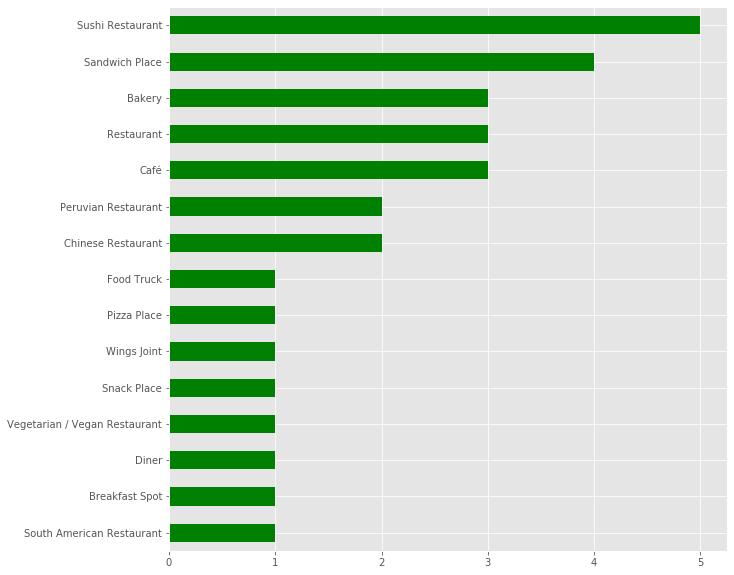

In [110]:
df_1stgroup = stgo_merged.loc[stgo_merged['Cluster Labels'] == 0, only_venues]
df1_list = []
for j in only_venues:
    df1_list = df1_list + df_1stgroup[j].to_list()
    
counter_df1 = Counter(df1_list)
df1 = pd.Series(counter_df1)
df1.sort_values(ascending=True, inplace=True)
g1 = df1
g1.plot(kind='barh', figsize=(10, 10), color='green')

In [97]:
df_1stgroup

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
295,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant
297,Chinese Restaurant,Fried Chicken Joint,Food Truck
302,Chinese Restaurant,Sushi Restaurant,Fast Food Restaurant
312,Chinese Restaurant,Bakery,Pizza Place
318,Fast Food Restaurant,Asian Restaurant,Chinese Restaurant
319,Chinese Restaurant,Fast Food Restaurant,Restaurant
320,Chinese Restaurant,Asian Restaurant,Restaurant


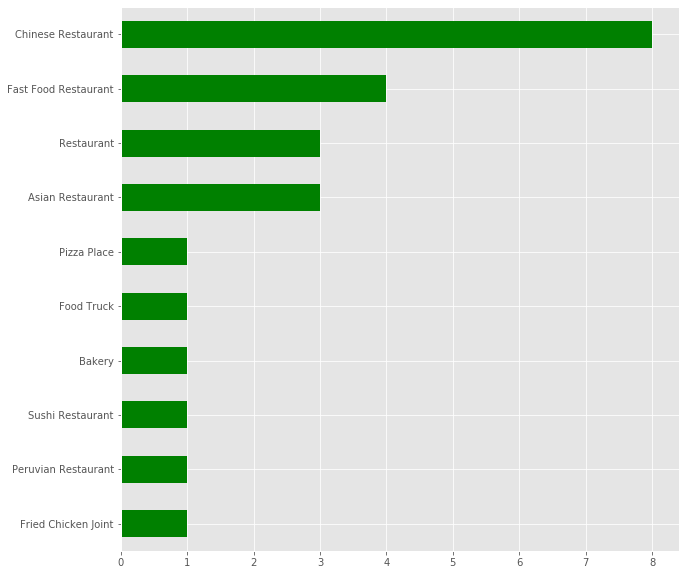

In [111]:
df_2stgroup = stgo_merged.loc[stgo_merged['Cluster Labels'] == 1, only_venues]
df2_list = []
for j in only_venues:
    df2_list = df2_list + df_2stgroup[j].to_list()
    
counter_df2 = Counter(df2_list)
df2 = pd.Series(counter_df2)
df2.sort_values(ascending=True, inplace=True)
g2 = df2
g2.plot(kind='barh', figsize=(10, 10), color='green')

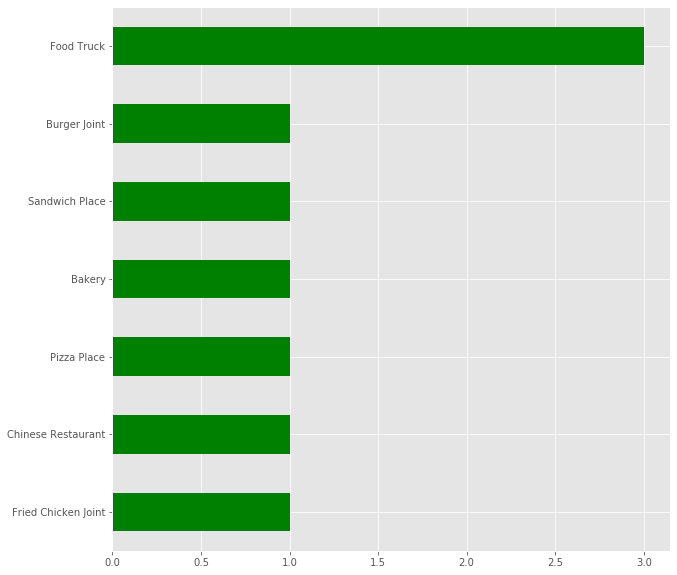

In [112]:
df_3stgroup = stgo_merged.loc[stgo_merged['Cluster Labels'] == 2, only_venues]
df3_list = []
for j in only_venues:
    df3_list = df3_list + df_3stgroup[j].to_list()
    
counter_df3 = Counter(df3_list)
df3 = pd.Series(counter_df3)
df3.sort_values(ascending=True, inplace=True)
g3 = df3
g3.plot(kind='barh', figsize=(10, 10), color='green')

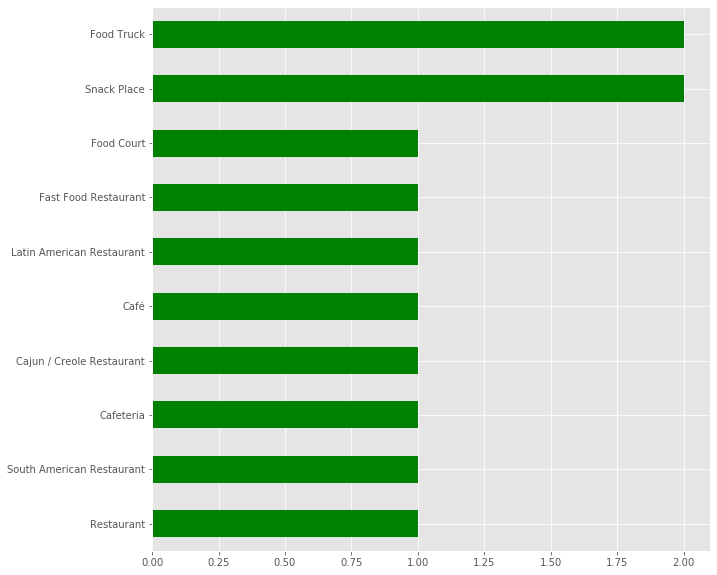

In [113]:
df_4stgroup = stgo_merged.loc[stgo_merged['Cluster Labels'] == 3, only_venues]
df4_list = []
for j in only_venues:
    df4_list = df4_list + df_4stgroup[j].to_list()
    
counter_df4 = Counter(df4_list)
df4 = pd.Series(counter_df4)
df4.sort_values(ascending=True, inplace=True)
g4 = df4
g4.plot(kind='barh', figsize=(10, 10), color='green')

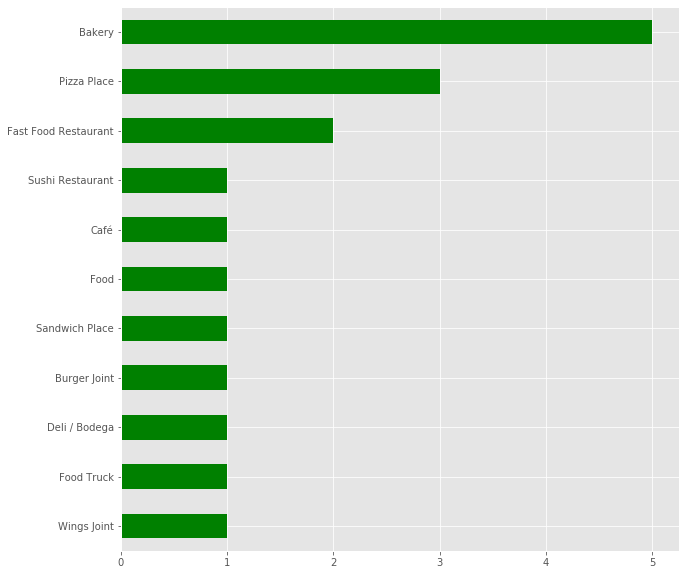

In [114]:
df_5stgroup = stgo_merged.loc[stgo_merged['Cluster Labels'] == 4, only_venues]
df5_list = []
for j in only_venues:
    df5_list = df5_list + df_5stgroup[j].to_list()
    
counter_df5 = Counter(df5_list)
df5 = pd.Series(counter_df5)
df5.sort_values(ascending=True, inplace=True)
g5 = df5
g5.plot(kind='barh', figsize=(10, 10), color='green')

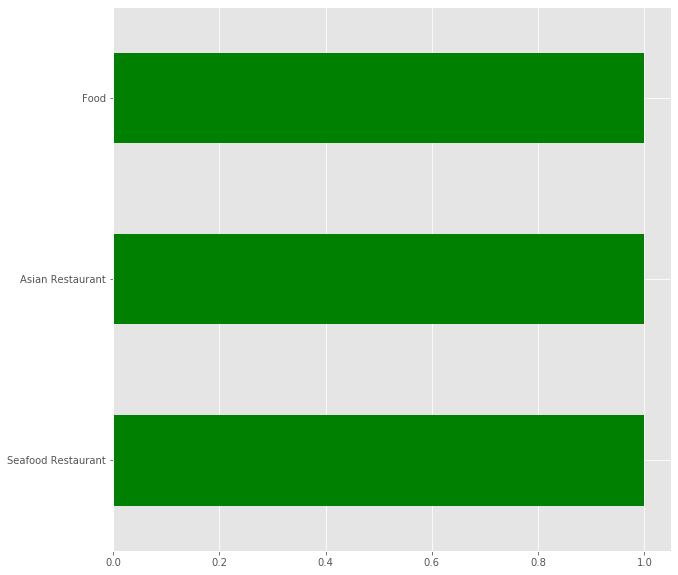

In [115]:
df_6stgroup = stgo_merged.loc[stgo_merged['Cluster Labels'] == 5, only_venues]
df6_list = []
for j in only_venues:
    df6_list = df6_list + df_6stgroup[j].to_list()
    
counter_df6 = Counter(df6_list)
df6 = pd.Series(counter_df6)
df6.sort_values(ascending=True, inplace=True)
g6 = df6
g6.plot(kind='barh', figsize=(10, 10), color='green')